In [1]:
#Install NumPy and Pandas in EMR Studio Notebook environment
spark.sparkContext.install_pypi_package("numpy")
spark.sparkContext.install_pypi_package("pandas")



VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1741883520155_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1741883520155_0002/container_1741883520155_0002_01_000001/tmp/spark-03ea0f55-d587-4b53-9f8b-c3666b686dd6
    Can't uninstall 'python-dateutil'. No files were found to uninstall.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.17.18 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.

In [2]:
# import packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, trim
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StandardScaler
import numpy as np
import pandas as pd




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Initialize SparkSession (if not already created)
spark = SparkSession.builder \
    .appName("Credit Risk Analysis") \
    .getOrCreate()

# Read CSV from S3
df = spark.read.csv(
    's3://credit-risk-analysis-final-project/loan.csv', 
    header=True, 
    inferSchema=True
)

# Verify data loading
print("Total rows:", df.count())
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total rows: 887379
root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = tr

In [11]:
# Show the first 5 rows of the DataFrame
df.show(5)

# We observe many NULLs

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+--------------------+--------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------

# Data cleaning and Preprocessing

In [4]:
# dropping columns missing more than 70% of data
from pyspark.sql.functions import col, count, when, isnull

def remove_high_missing_columns(df, missing_threshold=0.7):
    # Total number of rows in the dataset
    total_rows = df.count()
    
    # Calculate missing value percentages
    missing_analysis = df.select([
        (count(when(isnull(col(c)), c)) / total_rows).alias(c) 
        for c in df.columns
    ])
    
    # Identify columns with missing values above threshold
    columns_to_drop = []
    for column in df.columns:
        missing_pct = missing_analysis.select(column).collect()[0][column]
        
        if missing_pct > missing_threshold:
            columns_to_drop.append(column)
            print(f"Column '{column}' will be dropped. Missing percentage: {missing_pct * 100:.2f}%")
    
    # Drop identified columns
    if columns_to_drop:
        df_cleaned = df.drop(*columns_to_drop)
        print(f"\nTotal columns dropped: {len(columns_to_drop)}")
        print("Dropped columns:", columns_to_drop)
    else:
        df_cleaned = df
        print("No columns exceeded the missing value threshold.")
    
    return df_cleaned, columns_to_drop

# Usage
df_cleaned, dropped_columns = remove_high_missing_columns(df)

# Verify results
print("\nOriginal DataFrame Columns:", len(df.columns))
print("Cleaned DataFrame Columns:", len(df_cleaned.columns))

# Results:
#Total columns dropped: 20
#Dropped columns: ['desc', 'mths_since_last_record', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

#Original DataFrame Columns: 74
#Cleaned DataFrame Columns: 54

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Column 'desc' will be dropped. Missing percentage: 85.80%
Column 'mths_since_last_record' will be dropped. Missing percentage: 84.53%
Column 'mths_since_last_major_derog' will be dropped. Missing percentage: 74.99%
Column 'annual_inc_joint' will be dropped. Missing percentage: 99.92%
Column 'dti_joint' will be dropped. Missing percentage: 99.92%
Column 'verification_status_joint' will be dropped. Missing percentage: 99.93%
Column 'open_acc_6m' will be dropped. Missing percentage: 97.58%
Column 'open_il_6m' will be dropped. Missing percentage: 97.58%
Column 'open_il_12m' will be dropped. Missing percentage: 97.59%
Column 'open_il_24m' will be dropped. Missing percentage: 97.59%
Column 'mths_since_rcnt_il' will be dropped. Missing percentage: 97.65%
Column 'total_bal_il' will be dropped. Missing percentage: 97.59%
Column 'il_util' will be dropped. Missing percentage: 97.90%
Column 'open_rv_12m' will be dropped. Missing percentage: 97.59%
Column 'open_rv_24m' will be dropped. Missing perc

In [5]:
# Show remaining columns in my DataFrame
print("Remaining Columns:")
print(df_cleaned.columns)

# In a more detailed and formatted display
print("\nColumns in detailed view:")
for column in df_cleaned.columns:
    print(column)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Remaining Columns:
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

Columns in detailed view:
id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length

In [7]:
# Continue removing unncessary columns:

columns_to_drop = [
    'id', 'member_id', 'issue_d', 'url', 'title', 
    'zip_code', 'addr_state', 'policy_code', 
    'application_type', 'last_pymnt_d', 'last_pymnt_amnt', 
    'next_pymnt_d', 'last_credit_pull_d', 
    'collections_12_mths_ex_med', 'initial_list_status', 
    'recoveries', 'collections_12_mths_ex_med'
]

# Remove duplicate columns (if any)
columns_to_drop = list(set(columns_to_drop))

# Drop the specified columns
df_cleaned = df_cleaned.drop(*columns_to_drop)

# Verify results
print("Columns dropped:", columns_to_drop)
print("Original DataFrame Columns:", len(df.columns))
print("Cleaned DataFrame Columns:", len(df_cleaned.columns))

# Show remaining columns
print("\nRemaining Columns:")
print(df_cleaned.columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns dropped: ['url', 'application_type', 'last_pymnt_amnt', 'recoveries', 'policy_code', 'initial_list_status', 'next_pymnt_d', 'zip_code', 'issue_d', 'collections_12_mths_ex_med', 'id', 'addr_state', 'title', 'member_id', 'last_credit_pull_d', 'last_pymnt_d']
Original DataFrame Columns: 74
Cleaned DataFrame Columns: 38

Remaining Columns:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'collection_recovery_fee', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

In [8]:
# Check if out_prncp and out_prncp_inv have the same values. If so, drop one of the columns
# Check total number of rows where values differ
diff_count = df_cleaned.filter(col('out_prncp') != col('out_prncp_inv')).count()
print(f"Number of rows with different values: {diff_count}")

# If count is 0, prepare to drop one column
if diff_count == 0:
    # Drop out_prncp_inv
    df_cleaned = df_cleaned.drop('out_prncp_inv')
    print("Dropped 'out_prncp_inv' column")

# Verify columns
print("\nRemaining columns:")
print(df_cleaned.columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows with different values: 54222

Remaining columns:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'collection_recovery_fee', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

In [9]:
# seeing if we can drop 'mths_since_last_delinq' column
# Check missing values
missing_count = df_cleaned.filter(col('mths_since_last_delinq').isNull()).count()
total_rows = df_cleaned.count()
missing_percentage = (missing_count / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Missing values in 'mths_since_last_delinq': {missing_count}")
print(f"Missing percentage: {missing_percentage:.2f}%")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total rows: 887379
Missing values in 'mths_since_last_delinq': 454152
Missing percentage: 51.18%

In [10]:
# Since greater than 50%, drop 'mths_since_last_delinq':
df_cleaned = df_cleaned.drop('mths_since_last_delinq')
print("Remaining columns:")
for column in df_cleaned.columns:
    print(column)
    
# Total number of columns
print(f"Total number of columns: {len(df_cleaned.columns)}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Remaining columns:
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
loan_status
pymnt_plan
purpose
dti
delinq_2yrs
earliest_cr_line
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
total_acc
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
collection_recovery_fee
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_rev_hi_lim
Total number of columns: 37

In [11]:
# Further drop other unnecessary columns: 
# 'pymnt_plan', 'out_prncp', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'collection_recovery_fee', 'collection_recovery_fee', 'tot_coll_amt', 'tot_cur_bal', 'sub_grade', 'out_prncp_inv', 'total_rev_hi_lim', 'emp_title', 'acc_now_delinq'
df_cleaned = df_cleaned.drop('pymnt_plan', 'out_prncp', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'collection_recovery_fee', 'collection_recovery_fee', 'tot_coll_amt', 'tot_cur_bal', 'sub_grade', 'out_prncp_inv', 'total_rev_hi_lim', 'emp_title', 'acc_now_delinq')
print("Remaining columns:")
for column in df_cleaned.columns:
    print(column)
    
# Total number of columns
print(f"Total number of columns: {len(df_cleaned.columns)}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Remaining columns:
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
emp_length
home_ownership
annual_inc
verification_status
loan_status
purpose
dti
delinq_2yrs
earliest_cr_line
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
total_acc
Total number of columns: 22

In [21]:
# Export to CSV in S3 bucket
df_cleaned.write.csv(
    's3://credit-risk-analysis-final-project/cleaned_loan_data', 
    mode='overwrite',  # Overwrite existing files
    header=True        # Include column headers
)

print("Cleaned data exported successfully to S3 bucket.")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cleaned data exported successfully to S3 bucket.

Categorical columns are:  

    'grade',           # Risk category
    
    'emp_length',      # Employment duration
    
    'home_ownership',  # Residential status
    
    'verification_status',  # Income verification
    
    'purpose' 

In [12]:
# Analyzing unique values for the categorical columns
# Categorical columns to analyze
categorical_columns = [
    'grade',           # Risk category
    'emp_length',      # Employment duration
    'home_ownership',  # Residential status
    'verification_status',  # Income verification
    'purpose'          # Loan purpose
]

# Function to get unique values for each categorical column
def analyze_categorical_columns(df, columns):
    print("Unique Values Analysis:")
    for column in columns:
        print(f"\n{column.upper()} - Unique Values:")
        
        # Get unique values and their counts
        unique_values = df.groupBy(column) \
            .count() \
            .orderBy('count', ascending=False)
        
        unique_values.show(truncate=False)
        
        # Calculate total number of unique values
        total_unique = unique_values.count()
        print(f"Total unique values: {total_unique}")
        
        # Calculate percentage distribution
        total_rows = df.count()
        print("\nPercentage Distribution:")
        unique_values.withColumn('percentage', 
            (col('count') / total_rows * 100).cast('decimal(5,2)')
        ).show(truncate=False)

# Run the analysis
analyze_categorical_columns(df_cleaned, categorical_columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Unique Values Analysis:

GRADE - Unique Values:
+-----+------+
|grade|count |
+-----+------+
|B    |254535|
|C    |245860|
|A    |148202|
|D    |139542|
|E    |70705 |
|F    |23046 |
|G    |5489  |
+-----+------+

Total unique values: 7

Percentage Distribution:
+-----+------+----------+
|grade|count |percentage|
+-----+------+----------+
|B    |254535|28.68     |
|C    |245860|27.71     |
|A    |148202|16.70     |
|D    |139542|15.73     |
|E    |70705 |7.97      |
|F    |23046 |2.60      |
|G    |5489  |0.62      |
+-----+------+----------+


EMP_LENGTH - Unique Values:
+----------+------+
|emp_length|count |
+----------+------+
|10+ years |291569|
|2 years   |78869 |
|< 1 year  |70605 |
|3 years   |70026 |
|1 year    |57095 |
|5 years   |55704 |
|4 years   |52529 |
|n/a       |44825 |
|7 years   |44594 |
|8 years   |43955 |
|6 years   |42950 |
|9 years   |34657 |
| reactors"|1     |
+----------+------+

Total unique values: 13

Percentage Distribution:
+----------+------+----------+

In [34]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Encoding for 'Grade' column
def encode_grade(df):
    # StringIndexer
    grade_indexer = StringIndexer(
        inputCol='grade', 
        outputCol='grade_index',
        handleInvalid='keep'
    )
    
    # One-Hot Encoder
    grade_encoder = OneHotEncoder(
        inputCol='grade_index', 
        outputCol='grade_encoded'
    )
    
    # Fit and transform
    indexer_model = grade_indexer.fit(df)
    df_indexed = indexer_model.transform(df)
    
    encoder_model = grade_encoder.fit(df_indexed)
    df_final = encoder_model.transform(df_indexed)
    
    return df_final

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Encoding for 'emp_length' column
def encode_emp_length(df):
    # Remove 'reactors"' row
    df_cleaned = df.filter(col('emp_length') != 'reactors"')
    
    # StringIndexer
    emp_length_indexer = StringIndexer(
        inputCol='emp_length', 
        outputCol='emp_length_index',
        handleInvalid='keep'
    )
    
    # One-Hot Encoder
    emp_length_encoder = OneHotEncoder(
        inputCol='emp_length_index', 
        outputCol='emp_length_encoded'
    )
    
    # Fit and transform
    indexer_model = emp_length_indexer.fit(df_cleaned)
    df_indexed = indexer_model.transform(df_cleaned)
    
    encoder_model = emp_length_encoder.fit(df_indexed)
    df_final = encoder_model.transform(df_indexed)
    
    return df_final

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# Encoding for 'home_ownership
def encode_home_ownership(df):
    # Consolidate rare categories
    df_consolidated = df.withColumn('home_ownership_consolidated', 
        when(col('home_ownership').isin('MORTGAGE', 'RENT', 'OWN'), col('home_ownership'))
        .when(col('home_ownership').isin('NONE', 'ANY', '2 years'), 'OTHER')
        .otherwise('OTHER')
    )
    
    # StringIndexer
    home_ownership_indexer = StringIndexer(
        inputCol='home_ownership_consolidated', 
        outputCol='home_ownership_index',
        handleInvalid='keep'
    )
    
    # One-Hot Encoder
    home_ownership_encoder = OneHotEncoder(
        inputCol='home_ownership_index', 
        outputCol='home_ownership_encoded'
    )
    
    # Fit and transform
    indexer_model = home_ownership_indexer.fit(df_consolidated)
    df_indexed = indexer_model.transform(df_consolidated)
    
    encoder_model = home_ownership_encoder.fit(df_indexed)
    df_final = encoder_model.transform(df_indexed)
    
    return df_final

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
# Encoding for 'verification_status' 
def encode_verification_status(df):
    # Clean and consolidate verification status
    df_cleaned = df.withColumn('verification_status_cleaned', 
        when(col('verification_status').isin('Source Verified', 'Verified', 'Not Verified'), 
             col('verification_status'))
        .when(col('verification_status') == '38000.0', 'Not Verified')
        .otherwise('Not Verified')
    )
    
    # StringIndexer
    verification_status_indexer = StringIndexer(
        inputCol='verification_status_cleaned', 
        outputCol='verification_status_index',
        handleInvalid='keep'
    )
    
    # One-Hot Encoder
    verification_status_encoder = OneHotEncoder(
        inputCol='verification_status_index', 
        outputCol='verification_status_encoded'
    )
    
    # Fit and transform
    indexer_model = verification_status_indexer.fit(df_cleaned)
    df_indexed = indexer_model.transform(df_cleaned)
    
    encoder_model = verification_status_encoder.fit(df_indexed)
    df_final = encoder_model.transform(df_indexed)
    
    return df_final

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
# Encoding for 'purpose' 
def encode_purpose(df):
    # Consolidate categories
    df_consolidated = df.withColumn('purpose_consolidated', 
        when(col('purpose').isin(['debt_consolidation', 'credit_card']), col('purpose'))
        .when(col('purpose') == 'home_improvement', 'home_improvement')
        .otherwise('other')
    )
    
    # StringIndexer
    purpose_indexer = StringIndexer(
        inputCol='purpose_consolidated', 
        outputCol='purpose_index',
        handleInvalid='keep'
    )
    
    # One-Hot Encoder
    purpose_encoder = OneHotEncoder(
        inputCol='purpose_index', 
        outputCol='purpose_encoded'
    )
    
    # Fit and transform
    indexer_model = purpose_indexer.fit(df_consolidated)
    df_indexed = indexer_model.transform(df_consolidated)
    
    encoder_model = purpose_encoder.fit(df_indexed)
    df_final = encoder_model.transform(df_indexed)
    
    return df_final

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Check unique 'loan_status' values, which is our target variable
def analyze_loan_status(df):
    # Get unique values and their counts
    loan_status_counts = df.groupBy('loan_status') \
        .count() \
        .orderBy('count', ascending=False)
    
    print("Unique Loan Status Values:")
    loan_status_counts.show(truncate=False)
    
    # Calculate total rows and percentages
    total_rows = df.count()
    
    print("\nPercentage Distribution:")
    loan_status_counts.withColumn('percentage', 
        (col('count') / total_rows * 100).cast('decimal(5,2)')
    ).show(truncate=False)

# Binary Encoding Function
def encode_loan_status(df):
    df_encoded = df.withColumn('loan_status_binary', 
        when(col('loan_status') == 'Fully Paid', 0)
        .otherwise(1)
    )
    return df_encoded

# Call the analysis function
analyze_loan_status(df_cleaned)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Unique Loan Status Values:
+---------------------------------------------------+------+
|loan_status                                        |count |
+---------------------------------------------------+------+
|Current                                            |601778|
|Fully Paid                                         |207723|
|Charged Off                                        |45248 |
|Late (31-120 days)                                 |11591 |
|Issued                                             |8460  |
|In Grace Period                                    |6253  |
|Late (16-30 days)                                  |2357  |
|Does not meet the credit policy. Status:Fully Paid |1988  |
|Default                                            |1219  |
|Does not meet the credit policy. Status:Charged Off|761   |
|Oct-2015                                           |1     |
+---------------------------------------------------+------+


Percentage Distribution:
+------------------------------

I will be combining similar default indicators and will be excluding 'Current', 'Issued', and 'In Grace Period' from my dataset so that I can focus on definitive loan outcomes. This will provide me a clearer signal for default prediction. My binary encoding will be 1 = Default/High Risk, 0 = Non-Default/Low Risk. 

In [14]:
# Removing rows where 'loan_status' = 'Current', 'Issued', or 'In Grace Period'
# Handling all 5 categorical encodings by turning them into OneHotEncoding


from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder

def prepare_final_dataframe(df_cleaned):
    # 1. Remove rows with specific loan statuses
    df_filtered = df_cleaned.filter(
        ~col('loan_status').isin('Current', 'Issued', 'In Grace Period')
    )
    
    # 2. Grade Encoding
    grade_indexer = StringIndexer(
        inputCol='grade', 
        outputCol='grade_index',
        handleInvalid='keep'
    )
    grade_encoder = OneHotEncoder(
        inputCol='grade_index', 
        outputCol='grade_encoded'
    )
    grade_indexer_model = grade_indexer.fit(df_filtered)
    df_grade = grade_indexer_model.transform(df_filtered)
    grade_encoder_model = grade_encoder.fit(df_grade)
    df_grade = grade_encoder_model.transform(df_grade)
    
    # 3. Employment Length Encoding
    # Remove 'reactors"' row
    df_emp = df_grade.filter(col('emp_length') != 'reactors"')
    
    emp_length_indexer = StringIndexer(
        inputCol='emp_length', 
        outputCol='emp_length_index',
        handleInvalid='keep'
    )
    emp_length_encoder = OneHotEncoder(
        inputCol='emp_length_index', 
        outputCol='emp_length_encoded'
    )
    emp_length_indexer_model = emp_length_indexer.fit(df_emp)
    df_emp = emp_length_indexer_model.transform(df_emp)
    emp_length_encoder_model = emp_length_encoder.fit(df_emp)
    df_emp = emp_length_encoder_model.transform(df_emp)
    
    # 4. Home Ownership Encoding
    df_home = df_emp.withColumn('home_ownership_consolidated', 
        when(col('home_ownership').isin('MORTGAGE', 'RENT', 'OWN'), col('home_ownership'))
        .when(col('home_ownership').isin('NONE', 'ANY', '2 years'), 'OTHER')
        .otherwise('OTHER')
    )
    
    home_ownership_indexer = StringIndexer(
        inputCol='home_ownership_consolidated', 
        outputCol='home_ownership_index',
        handleInvalid='keep'
    )
    home_ownership_encoder = OneHotEncoder(
        inputCol='home_ownership_index', 
        outputCol='home_ownership_encoded'
    )
    home_ownership_indexer_model = home_ownership_indexer.fit(df_home)
    df_home = home_ownership_indexer_model.transform(df_home)
    home_ownership_encoder_model = home_ownership_encoder.fit(df_home)
    df_home = home_ownership_encoder_model.transform(df_home)
    
    # 5. Verification Status Encoding
    df_verification = df_home.withColumn('verification_status_cleaned', 
        when(col('verification_status').isin('Source Verified', 'Verified', 'Not Verified'), 
             col('verification_status'))
        .when(col('verification_status') == '38000.0', 'Not Verified')
        .otherwise('Not Verified')
    )
    
    verification_status_indexer = StringIndexer(
        inputCol='verification_status_cleaned', 
        outputCol='verification_status_index',
        handleInvalid='keep'
    )
    verification_status_encoder = OneHotEncoder(
        inputCol='verification_status_index', 
        outputCol='verification_status_encoded'
    )
    verification_status_indexer_model = verification_status_indexer.fit(df_verification)
    df_verification = verification_status_indexer_model.transform(df_verification)
    verification_status_encoder_model = verification_status_encoder.fit(df_verification)
    df_verification = verification_status_encoder_model.transform(df_verification)
    
    # 6. Purpose Encoding
    df_purpose = df_verification.withColumn('purpose_consolidated', 
        when(col('purpose').isin(['debt_consolidation', 'credit_card']), col('purpose'))
        .when(col('purpose') == 'home_improvement', 'home_improvement')
        .otherwise('other')
    )
    
    purpose_indexer = StringIndexer(
        inputCol='purpose_consolidated', 
        outputCol='purpose_index',
        handleInvalid='keep'
    )
    purpose_encoder = OneHotEncoder(
        inputCol='purpose_index', 
        outputCol='purpose_encoded'
    )
    purpose_indexer_model = purpose_indexer.fit(df_purpose)
    df_purpose = purpose_indexer_model.transform(df_purpose)
    purpose_encoder_model = purpose_encoder.fit(df_purpose)
    df_purpose = purpose_encoder_model.transform(df_purpose)
    
    # 7. Loan Status Encoding
    df_final = df_purpose.withColumn('loan_status_binary', 
        when(col('loan_status').isin(
            'Charged Off', 
            'Late (31-120 days)', 
            'Late (16-30 days)', 
            'Default',
            'Does not meet the credit policy. Status:Charged Off'
        ), 1)  # Default/High Risk
        .when(col('loan_status').isin(
            'Fully Paid',
            'Does not meet the credit policy. Status:Fully Paid'
        ), 0)  # Non-Default/Low Risk
    )
    
    return df_final

# Execute the processing
df_final = prepare_final_dataframe(df_cleaned)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
requirement failed: Column grade must be of type numeric but was actually of type string.
Traceback (most recent call last):
  File "<stdin>", line 16, in prepare_final_dataframe
  File "/mnt/yarn/usercache/livy/appcache/application_1741744095678_0001/container_1741744095678_0001_01_000001/pyspark.zip/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
  File "/mnt/yarn/usercache/livy/appcache/application_1741744095678_0001/container_1741744095678_0001_01_000001/pyspark.zip/pyspark/ml/wrapper.py", line 381, in _fit
    java_model = self._fit_java(dataset)
  File "/mnt/yarn/usercache/livy/appcache/application_1741744095678_0001/container_1741744095678_0001_01_000001/pyspark.zip/pyspark/ml/wrapper.py", line 378, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/mnt/yarn/usercache/livy/appcache/application_1741744095678_0001/container_1741744095678_0001_01_000001/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1322, in __call__
 

In [18]:
# Convert to Pandas DataFrame
columns_to_show = [
    'grade_index', 
    'grade_encoded', 
    'emp_length_index', 
    'emp_length_encoded', 
    'home_ownership_consolidated', 
    'home_ownership_index', 
    'home_ownership_encoded', 
    'verification_status_cleaned', 
    'verification_status_index', 
    'verification_status_encoded', 
    'purpose_consolidated', 
    'purpose_index', 
    'purpose_encoded', 
    'loan_status_binary'
]

# Convert to Pandas DataFrame
pandas_df = df_final.select(columns_to_show).limit(20).toPandas()

# Set display options for better readability
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

# Display the DataFrame
print(pandas_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    grade_index                        grade_encoded  emp_length_index                                                 emp_length_encoded home_ownership_consolidated  home_ownership_index home_ownership_encoded verification_status_cleaned  verification_status_index verification_status_encoded purpose_consolidated  purpose_index       purpose_encoded  loan_status_binary
0           0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)               0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)                        RENT                   1.0   (0.0, 1.0, 0.0, 0.0)                    Verified                        0.0             (1.0, 0.0, 0.0)          credit_card            1.0  (0.0, 1.0, 0.0, 0.0)                   0
1           1.0  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)               2.0  (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)                        RENT                   1.0   (0.0, 1.0, 0.0, 0.0)             Source Verified                  

In [26]:
# remove all columns we used as intermediate steps to OneHotEncode for our categorical variables to keep only the encoded and original columns
columns_to_drop = ['grade','grade_index', 'emp_length_index', 'home_ownership','home_ownership_index', 'verification_status_index', 'purpose_index', 'home_ownership_consolidated','verification_status_cleaned', 'purpose_consolidated', 'verification_status','purpose','emp_length','loan_status']
df_final = df_final.drop(*columns_to_drop)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
df_final.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'grade_encoded', 'emp_length_encoded', 'home_ownership_encoded', 'verification_status_encoded', 'purpose_encoded', 'loan_status_binary']

In [28]:
# need to deal with 'term' and 'earliest_cr_line'
# let us take a look at their unique values
from pyspark.sql.functions import col, count, countDistinct

# Function to calculate percentage distribution
def show_value_distribution(df, column):
    total_rows = df.count()
    
    distribution = df.groupBy(column) \
        .agg(
            count(column).alias('count'), 
            (count(column) / total_rows * 100).alias('percentage')
        ) \
        .orderBy('count', ascending=False)
    
    print(f"\nDistribution for '{column}':")
    distribution.show(truncate=False)

# Show distribution for 'term'
show_value_distribution(df_final, 'term')

# Show distribution for 'earliest_cr_line'
show_value_distribution(df_final, 'earliest_cr_line')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Distribution for 'term':
+----------+------+-----------------+
|term      |count |percentage       |
+----------+------+-----------------+
| 36 months|208320|76.90263134579605|
| 60 months|62568 |23.09736865420395|
+----------+------+-----------------+


Distribution for 'earliest_cr_line':
+----------------+-----+------------------+
|earliest_cr_line|count|percentage        |
+----------------+-----+------------------+
|Oct-2000        |2235 |0.8250642331886241|
|Oct-2001        |2094 |0.773013201027731 |
|Oct-1999        |2077 |0.766737544667907 |
|Nov-2000        |2051 |0.7571394819999409|
|Aug-2000        |2036 |0.7516021381530374|
|Nov-1999        |2009 |0.741634919228611 |
|Aug-2001        |1915 |0.706934231121349 |
|Sep-2000        |1871 |0.6906913558370987|
|Dec-2000        |1855 |0.684784855733735 |
|Sep-2001        |1827 |0.6744484805528485|
|Oct-2002        |1816 |0.6703877617317858|
|Dec-1998        |1790 |0.6607896990638198|
|Dec-1999        |1790 |0.6607896990638198|
|Au

In [33]:
from pyspark.sql.functions import regexp_replace, col

# Convert term to numeric
df_final = df_final.withColumn('term_numeric', 
    regexp_replace(col('term'), ' months', '').cast('int')
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
df_final.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'grade_encoded', 'emp_length_encoded', 'home_ownership_encoded', 'verification_status_encoded', 'purpose_encoded', 'loan_status_binary', 'term_numeric', 'term_encoded']

In [35]:
# remove term and term_encoded
columns_to_drop = ['term', 'term_encoded']
df_final = df_final.drop(*columns_to_drop)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
df_final.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'grade_encoded', 'emp_length_encoded', 'home_ownership_encoded', 'verification_status_encoded', 'purpose_encoded', 'loan_status_binary', 'term_numeric']

In [37]:
# Show unique values of 'term' and their counts
print("Unique Values of term_numeric:")
df_final.groupBy('term_numeric') \
    .count() \
    .orderBy('count', ascending=False) \
    .show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Unique Values of term_numeric:
+------------+------+
|term_numeric| count|
+------------+------+
|          36|208320|
|          60| 62568|
+------------+------+

In [38]:
# Show unique values for 'earliest_cr_line'
# Show unique values
print("Unique Values of earliest_cr_line:")
df_final.select('earliest_cr_line').distinct().show(truncate=False)

# Show count of unique values
print("\nCount of Unique Values:")
df_final.groupBy('earliest_cr_line') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(truncate=False)

# Calculate percentage distribution
total_rows = df_final.count()

print("\nPercentage Distribution:")
df_final.groupBy('earliest_cr_line') \
    .agg(
        count('earliest_cr_line').alias('count'),
        (count('earliest_cr_line') / total_rows * 100).alias('percentage')
    ) \
    .orderBy('count', ascending=False) \
    .show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Unique Values of earliest_cr_line:
+-------------------+
|earliest_cr_line   |
+-------------------+
|NULL               |
|1.0                |
|Jun-1985           |
|Apr-1988           |
|Sep-2003           |
|Nov-2002           |
|Dec-1966           |
|Jul-2009           |
|Sep-1973           |
|660xx              |
|Oct-1999           |
|May-1970           |
|480xx              |
|Sep-2008           |
|Nov-2008           |
|Jul-1970           |
|Nov-1977           |
|Jan-1994           |
|Small Business Loan|
|Jul-1999           |
+-------------------+
only showing top 20 rows


Count of Unique Values:
+----------------+-----+
|earliest_cr_line|count|
+----------------+-----+
|Oct-2000        |2235 |
|Oct-2001        |2094 |
|Oct-1999        |2077 |
|Nov-2000        |2051 |
|Aug-2000        |2036 |
|Nov-1999        |2009 |
|Aug-2001        |1915 |
|Sep-2000        |1871 |
|Dec-2000        |1855 |
|Sep-2001        |1827 |
|Oct-2002        |1816 |
|Dec-1998        |1790 |
|Dec-1999  

In [41]:
# converting to numeric feature for earliest_cr_line

from pyspark.sql.functions import col, when, regexp_replace, to_date, datediff, lit

df_final = df_final.withColumn('earliest_cr_line_cleaned', 
    when(col('earliest_cr_line').rlike('^[A-Za-z]{3}-\\d{4}$'), 
         to_date(col('earliest_cr_line'), 'MMM-yyyy'))
    .when(col('earliest_cr_line') == 'NULL', None)
    .when(col('earliest_cr_line') == '1.0', None)
    .when(col('earliest_cr_line').rlike('^\\d+xx$'), None)
    .when(col('earliest_cr_line') == 'Small Business Loan', None)
    .otherwise(to_date(col('earliest_cr_line'), 'MMM-yyyy'))
)

# Calculate credit history length in years using a fixed reference date
reference_date = lit('2025-01-01')

df_final = df_final.withColumn('credit_history_length', 
    when(col('earliest_cr_line_cleaned').isNotNull(), 
         datediff(reference_date, col('earliest_cr_line_cleaned')) / 365.25)
    .otherwise(None)
)

# Optional: Remove rows with invalid credit history if needed
df_final = df_final.filter(col('credit_history_length').isNotNull())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# Show unique values of earliest_cr_line_cleaned
print("Unique Values of earliest_cr_line_cleaned:")
df_final.select('earliest_cr_line_cleaned').distinct().show(truncate=False)

# Show unique values of credit_history_length
print("\nUnique Values of credit_history_length:")
df_final.select('credit_history_length').distinct().orderBy('credit_history_length').show(truncate=False)

# Statistical summary of credit_history_length
print("\nStatistical Summary of credit_history_length:")
df_final.select('credit_history_length').summary().show()

# Distribution of credit_history_length
print("\nDistribution of credit_history_length:")
df_final.groupBy(
    when((col('credit_history_length') < 5), "0-5 years")
    .when((col('credit_history_length') >= 5) & (col('credit_history_length') < 10), "5-10 years")
    .when((col('credit_history_length') >= 10) & (col('credit_history_length') < 15), "10-15 years")
    .otherwise("15+ years")
).count().orderBy('count', ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Unique Values of earliest_cr_line_cleaned:
+------------------------+
|earliest_cr_line_cleaned|
+------------------------+
|1999-02-01              |
|1995-12-01              |
|1961-11-01              |
|1978-11-01              |
|1970-09-01              |
|2006-12-01              |
|2010-12-01              |
|2004-11-01              |
|1969-07-01              |
|2007-08-01              |
|2000-09-01              |
|1960-12-01              |
|1997-07-01              |
|2000-08-01              |
|1971-08-01              |
|2004-04-01              |
|2006-10-01              |
|1976-11-01              |
|1968-08-01              |
|1994-03-01              |
+------------------------+
only showing top 20 rows


Unique Values of credit_history_length:
+---------------------+
|credit_history_length|
+---------------------+
|12.251882272416154   |
|12.41889117043121    |
|12.503764544832306   |
|12.58590006844627    |
|12.670773442847365   |
|12.752908966461328   |
|12.837782340862423   |
|1

In [43]:
# we are going to go with using 'credit_history_length' for measurement, instead of 'earliest_cr_line_cleaned' as it is more interpretable and directly represent's the borrower's credit experience. Dates are also harder for models to process
# Let us drop the column 'earliest_cr_line_cleaned'

df_final.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'grade_encoded', 'emp_length_encoded', 'home_ownership_encoded', 'verification_status_encoded', 'purpose_encoded', 'loan_status_binary', 'term_numeric', 'earliest_cr_line_cleaned', 'credit_history_length']

In [44]:
# Let us drop the column 'earliest_cr_line_cleaned' and 'earliest_cr_line'
columns_to_drop = ['earliest_cr_line_cleaned', 'earliest_cr_line']

df_final = df_final.drop(*columns_to_drop)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
df_final.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'grade_encoded', 'emp_length_encoded', 'home_ownership_encoded', 'verification_status_encoded', 'purpose_encoded', 'loan_status_binary', 'term_numeric', 'credit_history_length']

In [46]:
# Analyze unique values of columns in df_final
columns_to_analyze = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
    'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 
    'revol_bal', 'revol_util', 'total_acc', 'grade_encoded', 'emp_length_encoded', 
    'home_ownership_encoded', 'verification_status_encoded', 'purpose_encoded', 
    'loan_status_binary', 'term_numeric', 'credit_history_length'
]

# Function to show unique values and basic statistics
def analyze_column(df, column):
    print(f"\n--- Analysis for {column} ---")
    
    # Unique values
    print("\nUnique Values:")
    df.select(column).distinct().show(10, truncate=False)
    
    # Statistical summary for numeric columns
    try:
        print("\nStatistical Summary:")
        df.select(column).summary().show()
    except Exception as e:
        print(f"Could not generate summary: {e}")
    
    # Distribution for encoded/categorical columns
    if column.endswith('encoded') or column == 'loan_status_binary':
        print("\nValue Distribution:")
        df.groupBy(column).count().orderBy('count', ascending=False).show()

# Analyze each column
for column in columns_to_analyze:
    analyze_column(df_final, column)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


--- Analysis for loan_amnt ---

Unique Values:
+---------+
|loan_amnt|
+---------+
|10625.0  |
|21500.0  |
|10375.0  |
|11925.0  |
|16550.0  |
|24150.0  |
|15100.0  |
|22525.0  |
|21000.0  |
|23200.0  |
+---------+
only showing top 10 rows


Statistical Summary:
+-------+------------------+
|summary|         loan_amnt|
+-------+------------------+
|  count|            270606|
|   mean|13631.445163817505|
| stddev| 8165.519755677505|
|    min|             500.0|
|    25%|            7400.0|
|    50%|           12000.0|
|    75%|           18500.0|
|    max|           35000.0|
+-------+------------------+


--- Analysis for funded_amnt ---

Unique Values:
+-----------+
|funded_amnt|
+-----------+
|10625.0    |
|21500.0    |
|10375.0    |
|11925.0    |
|15100.0    |
|16550.0    |
|24150.0    |
|22525.0    |
|30525.0    |
|21000.0    |
+-----------+
only showing top 10 rows


Statistical Summary:
+-------+------------------+
|summary|       funded_amnt|
+-------+------------------+
|  cou

In [47]:
# Writing my transformed and pre-processed dataframe df_final to S3 in Parquet Format
df_final.write \
    .mode("overwrite") \
    .parquet("s3://credit-risk-analysis-final-project/credit-risk-data/")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
# getting all data types and schema information for df_final
print("Column Names and Data Types:")
for column, dtype in df_final.dtypes:
    print(f"{column}: {dtype}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Column Names and Data Types:
loan_amnt: double
funded_amnt: double
funded_amnt_inv: double
int_rate: double
installment: double
annual_inc: string
dti: string
delinq_2yrs: string
inq_last_6mths: string
open_acc: string
pub_rec: string
revol_bal: string
revol_util: string
total_acc: string
grade_encoded: vector
emp_length_encoded: vector
home_ownership_encoded: vector
verification_status_encoded: vector
purpose_encoded: vector
loan_status_binary: int
term_numeric: int
credit_history_length: double

In [3]:
# Resuming work. Loading df_final through parquet

# Initialize Spark Session (if it's not already initialized)
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Credit Risk Analysis").getOrCreate()

# Load the Parquet data from S3 into a DataFrame
df_final = spark.read.parquet("s3://credit-risk-analysis-final-project/credit-risk-data/")

# Verify the data was loaded correctly
print(f"Number of rows: {df_final.count()}")
print(f"Number of columns: {len(df_final.columns)}")

# Display the schema to confirm all columns loaded properly
df_final.printSchema()

# Show a small sample of the data
df_final.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows: 270606
Number of columns: 22
root
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- grade_encoded: vector (nullable = true)
 |-- emp_length_encoded: vector (nullable = true)
 |-- home_ownership_encoded: vector (nullable = true)
 |-- verification_status_encoded: vector (nullable = true)
 |-- purpose_encoded: vector (nullable = true)
 |-- loan_status_binary: integer (nullable = true)
 |-- term_numeric: integer (nullable = true)
 |-- credit_hist

Currently the format of my one-hot encoded vectors are in sparse vector representation format (example: (7,[1],[1.0])) from PySpark's MLib. This is not compatible with Athena's ARRAY type. As a result, we need to convert all my one-hot encoded sparse vectors into dense arrays and write it to Parquet later down the line. 

In [5]:
# Created a copy of the original dataframe (df_final) and named it df_transformed
# Converts only the vector columns to dense array while keeping all other columns within the dataframe
# Writes the completed dataframe with all columns to Parquet storage

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

# Create UDF to convert sparse vector to dense array
to_dense_array = udf(lambda v: v.toArray().tolist() if v else None, ArrayType(DoubleType()))

# List of vector columns to convert
vector_columns = ["grade_encoded", "emp_length_encoded", "home_ownership_encoded", 
                 "verification_status_encoded", "purpose_encoded"]

# Make a copy of the original DataFrame to modify
df_transformed = df_final

# Apply conversion to all vector columns (keeping original columns intact)
for col_name in vector_columns:
    # Create new column with dense array
    df_transformed = df_transformed.withColumn(f"{col_name}_array", to_dense_array(col_name))
    # Drop the original sparse vector column
    df_transformed = df_transformed.drop(col_name)

# Show the schema to verify changes
print("Number of columns:", len(df_transformed.columns))
df_transformed.printSchema()

# Show sample data with the converted columns
print("Sample of array columns:")
df_transformed.select([col for col in df_transformed.columns if "_array" in col]).show(3, truncate=False)

# Write the complete transformed DataFrame to Parquet (with ALL columns)
df_transformed.write.mode("overwrite").parquet("s3://credit-risk-analysis-final-project/complete-partquet-data-with-arrays/")

print("Successfully wrote DataFrame with all columns to Parquet.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns: 22
root
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- loan_status_binary: integer (nullable = true)
 |-- term_numeric: integer (nullable = true)
 |-- credit_history_length: double (nullable = true)
 |-- grade_encoded_array: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- emp_length_encoded_array: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- home_ownership_encoded_array: array

In [7]:
# Ran "SELECT * FROM credit_risk_data LIMIT 10;" to make sure table was properly created
# Successfully integrated Athena into my credit risk analyss workflow

#	loan_amnt	funded_amnt	funded_amnt_inv	int_rate	installment	annual_inc	dti	delinq_2yrs	inq_last_6mths	open_acc	pub_rec	revol_bal	revol_util	total_acc	loan_status_binary	term_numeric	credit_history_length	grade_encoded_array	emp_length_encoded_array	home_ownership_encoded_array	verification_status_encoded_array	purpose_encoded_array
# 1	33950.0	33950.0	33950.0	25.83	1013.07	85000.0	35.85	0.0	1.0	17.0	0.0	23615.0	62.3	24.0	0	60	47.9151266255989	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]	[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]	[0.0, 1.0, 0.0, 0.0]	[1.0, 0.0, 0.0]	[0.0, 0.0, 1.0, 0.0]
# 2	4300.0	4300.0	4300.0	17.57	154.53	40700.0	26.01	0.0	0.0	5.0	0.0	12470.0	92.4	7.0	0	36	18.915811088295687	[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]	[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]	[0.0, 1.0, 0.0, 0.0]	[0.0, 0.0, 1.0]	[1.0, 0.0, 0.0, 0.0]
# 3	3350.0	3350.0	3350.0	12.29	111.74	13700.0	29.71	0.0	0.0	8.0	1.0	4754.0	40.3	17.0	0	36	37.2539356605065	[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]	[0.0, 1.0, 0.0, 0.0]	[1.0, 0.0, 0.0]	[0.0, 0.0, 0.0, 1.0]
# 4	10050.0	10050.0	10050.0	25.99	300.85	42000.0	22.46	1.0	3.0	16.0	0.0	15410.0	66.4	30.0	1	60	25.672826830937716	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]	[0.0, 1.0, 0.0, 0.0]	[1.0, 0.0, 0.0]	[0.0, 1.0, 0.0, 0.0]
# 5	17625.0	17625.0	17625.0	25.8	525.62	52000.0	19.46	0.0	0.0	6.0	0.0	17298.0	95.6	25.0	0	60	28.251882272416154	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]	[1.0, 0.0, 0.0, 0.0]	[0.0, 1.0, 0.0]	[1.0, 0.0, 0.0, 0.0]
# 6	29325.0	29325.0	29075.0	24.5	852.16	70000.0	26.25	1.0	3.0	14.0	0.0	23034.0	71.1	47.0	1	60	24.418891170431213	[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]	[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]	[0.0, 1.0, 0.0, 0.0]	[0.0, 0.0, 1.0]	[1.0, 0.0, 0.0, 0.0]
# 7	13600.0	13600.0	13600.0	16.99	337.93	78000.0	11.4	2.0	1.0	8.0	0.0	13037.0	61.5	16.0	0	60	22.587268993839835	[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]	[1.0, 0.0, 0.0, 0.0]	[0.0, 0.0, 1.0]	[1.0, 0.0, 0.0, 0.0]
# 8	12075.0	12075.0	12075.0	22.99	467.36	40373.0	18.58	0.0	1.0	10.0	0.0	4057.0	88.2	15.0	1	36	20.251882272416154	[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]	[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]	[0.0, 1.0, 0.0, 0.0]	[1.0, 0.0, 0.0]	[1.0, 0.0, 0.0, 0.0]
# 9	30225.0	30225.0	30225.0	19.52	792.73	72000.0	12.5	0.0	0.0	6.0	0.0	7488.0	65.7	23.0	1	60	20.917180013689254	[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]	[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]	[1.0, 0.0, 0.0, 0.0]	[1.0, 0.0, 0.0]	[1.0, 0.0, 0.0, 0.0]
# 10	10700.0	10700.0	10700.0	10.99	350.26	75000.0	11.23	1.0	0.0	7.0	0.0	5298.0	42.7	23.0	0	36	24.83778234086242	[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]	[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]	[1.0, 0.0, 0.0, 0.0]	[0.0, 1.0, 0.0]	[1.0, 0.0, 0.0, 0.0]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Install boto3 using PySpark's package installer
spark.sparkContext.install_pypi_package("boto3")

# Verify it's available
try:
    import boto3
    print("boto3 successfully imported, version:", boto3.__version__)
except ImportError as e:
    print("Import failed:", e)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


boto3 successfully imported, version: 1.37.11

In [4]:
# restarted kernel after boto3 installation
# resuming work

# 1. Import libraries
import boto3
from pyspark.sql import SparkSession
# Any other libraries you were using

# 2. Initialize Spark session
spark = SparkSession.builder.appName("Credit Risk Analysis").getOrCreate()

# 3. Load your Parquet data
df_final = spark.read.parquet("s3://credit-risk-analysis-final-project/complete-partquet-data-with-arrays/")

# Verify data loaded correctly
print(f"DataFrame loaded with {df_final.count()} rows and {len(df_final.columns)} columns")
df_final.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame loaded with 270606 rows and 22 columns
root
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- loan_status_binary: integer (nullable = true)
 |-- term_numeric: integer (nullable = true)
 |-- credit_history_length: double (nullable = true)
 |-- grade_encoded_array: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- emp_length_encoded_array: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- home_own

In [5]:
# Set up AWS credentials for Athena and S3. 
# If you set up AWS credentials for Athena or S3, you don't need to define them again for S3 access in the same session. The boto3 library will use the same credentials for all AWS services by default.
# Need to re-configure credentials each time we start a new aws session
import boto3

# Configure Athena client with credentials


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# define a function to run Athena queries, specifying which Athena database to use, where to save query results (in S3). 
import time

def run_athena_query(query, athena_client, database, s3_output):
    """
    Execute a query against Athena and wait for it to complete
    
    Parameters:
    query (str): SQL query to execute
    athena_client: Boto3 Athena client
    database (str): Athena database name
    s3_output (str): S3 location for query results
    
    Returns:
    str: Query execution ID
    """
    # Start the query execution
    response = athena_client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={'Database': database},
        ResultConfiguration={'OutputLocation': s3_output}
    )
    
    query_execution_id = response['QueryExecutionId']
    
    # Wait for query to complete
    state = 'RUNNING'
    while state in ['RUNNING', 'QUEUED']:
        response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
        state = response['QueryExecution']['Status']['State']
        
        if state == 'FAILED':
            error_message = response['QueryExecution']['Status'].get('StateChangeReason', 'Query failed')
            raise Exception(f"Query failed: {error_message}")
        
        if state == 'SUCCEEDED':
            break
            
        time.sleep(1)  # Wait 1 second before checking again
    
    return query_execution_id



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# now we have to set up the query parameters 
database = 'credit_risk_db'  # This will be passed as the 'database' parameter
output_location = 's3://credit-risk-analysis-final-project/athena-results/'  # This will be passed as the 's3_output' parameter
table_name = 'credit_risk_data_arrays'  # This is used to build the query

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Defining a SQL query to extract the data I need from Athena
# Query to select data for machine learning: Select all the data
full_query = f"SELECT * FROM {table_name}"


# Execute the query
print("Querying full dataset from Athena...")
query_execution_id = run_athena_query(full_query, athena_client, database, output_location)
print(f"Query completed. Execution ID: {query_execution_id}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Querying full dataset from Athena...
Query completed. Execution ID: b32dd8e9-055b-4659-8bf9-2f9c6f5a9c74

In [9]:
# Retrieve the results from S3
# Create S3 client with your credentials
#s3_client = boto3.client('s3',
    #aws_access_key_id='your_access_key_id',  # your access key
    #aws_secret_access_key='your_aws_secret_access_key',  # your secret access key
    #aws_session_token='your_aws_session_key',
    #region_name = 'us-east-1')

# Get the S3 path to the query results
results_path = f"{output_location}{query_execution_id}.csv"
bucket_name = results_path.replace('s3://', '').split('/')[0]
object_key = results_path.replace(f's3://{bucket_name}/', '')

# Read the results directly into a Spark DataFrame
print("Loading query results into Spark...")
data_path = f"s3://{bucket_name}/{object_key}"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Check the data
print(f"Loaded {df.count()} rows with {len(df.columns)} columns")
df.printSchema()

# This reads your query results directly into a Spark DataFrame, which is more memory-efficient than loading into pandas

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Loading query results into Spark...
Loaded 270606 rows with 22 columns
root
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- open_acc: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- loan_status_binary: integer (nullable = true)
 |-- term_numeric: integer (nullable = true)
 |-- credit_history_length: double (nullable = true)
 |-- grade_encoded_array: string (nullable = true)
 |-- emp_length_encoded_array: string (nullable = true)
 |-- home_ownership_encoded_array: string (nullable = true)
 |-- verification_status_

In [15]:
# examining our schema to understand the data
df.printSchema()

# show a sample of the data (first 5 rows)
df.show(5)

# checking the row and count distribution of target variable loan_status_binary
print(f"Total rows: {df.count()}")
print("Class distribution:")
df.groupBy("loan_status_binary").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- open_acc: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- loan_status_binary: integer (nullable = true)
 |-- term_numeric: integer (nullable = true)
 |-- credit_history_length: double (nullable = true)
 |-- grade_encoded_array: string (nullable = true)
 |-- emp_length_encoded_array: string (nullable = true)
 |-- home_ownership_encoded_array: string (nullable = true)
 |-- verification_status_encoded_array: string (nullable = true)
 |-- purpose_encoded_array: str

In [12]:
# Check and process the array columns (for our categorical variables)
# First checks the format of the array columns. Converts them into actual python arrays, then converts them to vectors for ML processing. 
import ast
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, DoubleType

# Define the array columns
array_cols = ['grade_encoded_array', 'emp_length_encoded_array', 'home_ownership_encoded_array',
              'verification_status_encoded_array', 'purpose_encoded_array']

# First, convert strings to actual arrays with a UDF
def parse_array_string(s):
    if isinstance(s, str):
        try:
            return ast.literal_eval(s)
        except:
            return []
    return s

# Register UDF for string to array conversion
parse_array_udf = udf(parse_array_string, ArrayType(DoubleType()))

# Apply string to array conversion
for array_col in array_cols:
    df = df.withColumn(array_col, parse_array_udf(df[array_col]))

# Now convert arrays to vectors
array_to_vector = udf(lambda arr: Vectors.dense(arr) if arr else Vectors.dense([0.0]), VectorUDT())

# Apply the array to vector UDF
for array_col in array_cols:
    df = df.withColumn(
        f"{array_col}_vec",
        array_to_vector(df[array_col])
    )

# Verify conversion worked
print("Verification: Checking processed columns")
sample_vec_col = df.select(f"{array_cols[0]}_vec").first()
print(f"Vector column type: {type(sample_vec_col[0])}")
print("Array processing complete")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Verification: Checking processed columns
Vector column type: <class 'pyspark.ml.linalg.DenseVector'>
Array processing complete

In [14]:
# 1. we need to identify and standardize our numeric features

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

# Define numeric columns
numeric_cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
                'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 
                'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'term_numeric', 
                'credit_history_length']

# Create standardization pipeline for each numeric column
standardizers = []
scaled_cols = []

for num_col in numeric_cols:
    # Create a unique suffix for each column to avoid conflicts
    import uuid
    suffix = uuid.uuid4().hex[:4]
    
    vec_col = f"{num_col}_vec_{suffix}"
    scaled_col = f"{num_col}_scaled_{suffix}"
    
    # Create vector assembler for this column
    assembler = VectorAssembler(
        inputCols=[num_col],
        outputCol=vec_col,
        handleInvalid="skip"
    )
    
    # Create scaler for this column
    scaler = StandardScaler(
        inputCol=vec_col,
        outputCol=scaled_col,
        withStd=True,
        withMean=True
    )
    
    standardizers.extend([assembler, scaler])
    scaled_cols.append(scaled_col)

# Apply standardization pipeline
standardize_pipeline = Pipeline(stages=standardizers)
scaler_model = standardize_pipeline.fit(df)
df_scaled = scaler_model.transform(df)

print(f"Standardized {len(numeric_cols)} numeric features")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Standardized 16 numeric features

In [18]:
# Recalculate class distribution for train_df
from pyspark.sql.functions import when, col

print("Rechecking class balance...")
class_counts = train_df.groupBy("loan_status_binary").count().collect()
total_count = sum(row["count"] for row in class_counts)

for row in class_counts:
    label = row["loan_status_binary"]
    count = row["count"]
    percentage = (count / total_count) * 100
    print(f"Class {label}: {count} rows ({percentage:.2f}%)")

# Determine if there's significant imbalance
majority_class = max(class_counts, key=lambda x: x["count"])
minority_class = min(class_counts, key=lambda x: x["count"])
imbalance_ratio = majority_class["count"] / minority_class["count"]
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# Set weights inversely proportional to class frequencies
weights = {
    majority_class["loan_status_binary"]: 1.0,
    minority_class["loan_status_binary"]: imbalance_ratio
}

# Now add class weights to train and test sets
train_df = train_df.withColumn(
    "classWeight",
    when(col("loan_status_binary") == majority_class["loan_status_binary"], 
         weights[majority_class["loan_status_binary"]])
    .otherwise(weights[minority_class["loan_status_binary"]])
)

test_df = test_df.withColumn(
    "classWeight",
    when(col("loan_status_binary") == majority_class["loan_status_binary"], 
         weights[majority_class["loan_status_binary"]])
    .otherwise(weights[minority_class["loan_status_binary"]])
)

print(f"Applied weights: {weights}")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Rechecking class balance...
Class 1: 48804 rows (22.56%)
Class 0: 167506 rows (77.44%)
Imbalance ratio: 3.43:1
Applied weights: {0: 1.0, 1: 3.4322186706007702}

In [23]:
# Preparing final features for machine learning
# Combines both my "scaledNumericFeatures" which is a single vector containing all of my standardized numeric features combined in step 5, and combines it with "vector_cols" which are my one-hot encoded categorical features. 
# VectorAssembler combines the multiple feature columns into a single vector called "features", which is required as Spark ML algos expect all features to be in a single vector column. 
# VectorAssembler then gets applied to our dataframe, creating the final "features" column that contains the complete feature vector for each row. Now each row has original data columns, intermediate processed columns, and a unified "features" column that the ML algorithms will use.
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Prepare feature vector from standardized numeric features and vector columns
vector_cols = [f"{col}_vec" for col in array_cols]

# Combine standardized numeric features with categorical vectors
feature_cols = scaled_cols + vector_cols

# Create final feature vector
final_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

# Apply assembler
ml_ready_df = final_assembler.transform(df_scaled)

# Split data
train_df, test_df = ml_ready_df.randomSplit([0.8, 0.2], seed=42)
print(f"Training set: {train_df.count()} rows")
print(f"Test set: {test_df.count()} rows")

# Add weights directly to train_df and test_df
from pyspark.sql.functions import when, col, lit

# Calculate class distribution
class_counts = train_df.groupBy("loan_status_binary").count().collect()

# Get majority and minority classes
majority_class = max(class_counts, key=lambda x: x["count"])["loan_status_binary"]
minority_class = min(class_counts, key=lambda x: x["count"])["loan_status_binary"]
imbalance_ratio = max(row["count"] for row in class_counts) / min(row["count"] for row in class_counts)

# Add classWeight column
train_df = train_df.withColumn(
    "classWeight", 
    when(col("loan_status_binary") == majority_class, 1.0)
    .otherwise(imbalance_ratio)
)

test_df = test_df.withColumn(
    "classWeight", 
    when(col("loan_status_binary") == majority_class, 1.0)
    .otherwise(imbalance_ratio)
)

# Verify the column was added
print(f"Added class weights: majority({majority_class})=1.0, minority({minority_class})={imbalance_ratio:.2f}")
print("'classWeight' in train_df columns:", 'classWeight' in train_df.columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training set: 216260 rows
Test set: 54125 rows
Added class weights: majority(0)=1.0, minority(1)=3.44
'classWeight' in train_df columns: True

In [24]:
# Train a random forest model
# For credit risk analysis, decided on Random Forest because it handles non-linear relationships well, is robust to outliers, provides feature importance for interpretability, typically performs well on imbalanced datasets, and doesn't overfit easily when using the proper tuning

from pyspark.ml.classification import RandomForestClassifier

# Initialize Random Forest classifier
rf = RandomForestClassifier(
    labelCol="loan_status_binary",
    featuresCol="features",
    weightCol="classWeight",
    numTrees=100,
    maxDepth=10,
    impurity="gini",
    featureSubsetStrategy="sqrt",
    seed=42
)

# Train the model
print("Training Random Forest model...")
model = rf.fit(train_df)

# Make predictions on test set
predictions = model.transform(test_df)
print("Model training and prediction complete")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Random Forest model...
Model training and prediction complete

In [25]:
# # install packages for visualizations
sc.install_pypi_package("python-detautil==2.8.2")
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("scikit-learn")
sc.install_pypi_package("seaborn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…





ERROR: Could not find a version that satisfies the requirement python-detautil==2.8.2 (from versions: none)
ERROR: No matching distribution found for python-detautil==2.8.2




In [26]:
# Evaluating the model 

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Set up evaluators
roc_evaluator = BinaryClassificationEvaluator(
    labelCol="loan_status_binary", 
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

pr_evaluator = BinaryClassificationEvaluator(
    labelCol="loan_status_binary", 
    rawPredictionCol="rawPrediction",
    metricName="areaUnderPR"
)

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="loan_status_binary",
    predictionCol="prediction",
    metricName="f1"
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="loan_status_binary",
    predictionCol="prediction",
    metricName="accuracy"
)

# Calculate metrics
roc_auc = roc_evaluator.evaluate(predictions)
pr_auc = pr_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)
accuracy = accuracy_evaluator.evaluate(predictions)

# Display results
print("\nModel Performance:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Model Performance:
ROC AUC: 0.7040
PR AUC: 0.4021
F1 Score: 0.6689
Accuracy: 0.6404

In [57]:
# Prepare data for visualizations

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Select necessary columns and convert to pandas
pred_pandas = predictions.select("loan_status_binary", "prediction", "probability").toPandas()

# Extract probability of class 1 (default)
pred_pandas["probability_1"] = pred_pandas["probability"].apply(lambda x: float(x[1]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

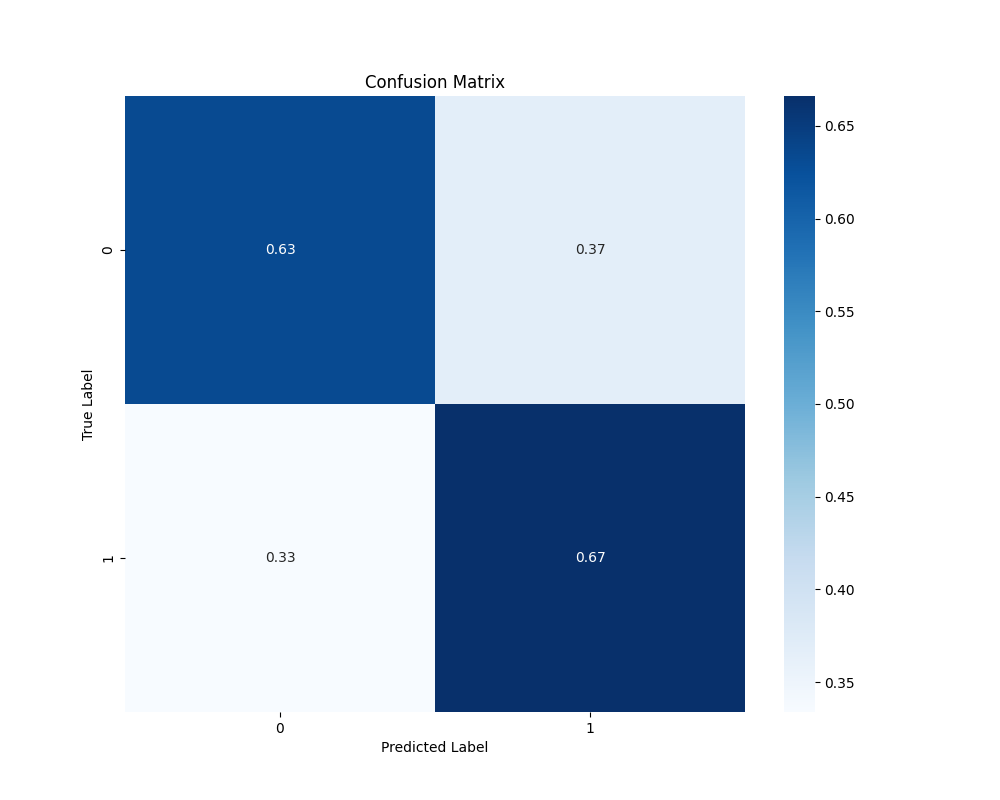

In [58]:
# Confusion Matrix

plt.figure(figsize=(10, 8))
cm = confusion_matrix(pred_pandas["loan_status_binary"], pred_pandas["prediction"])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Using magic command to display the plot
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

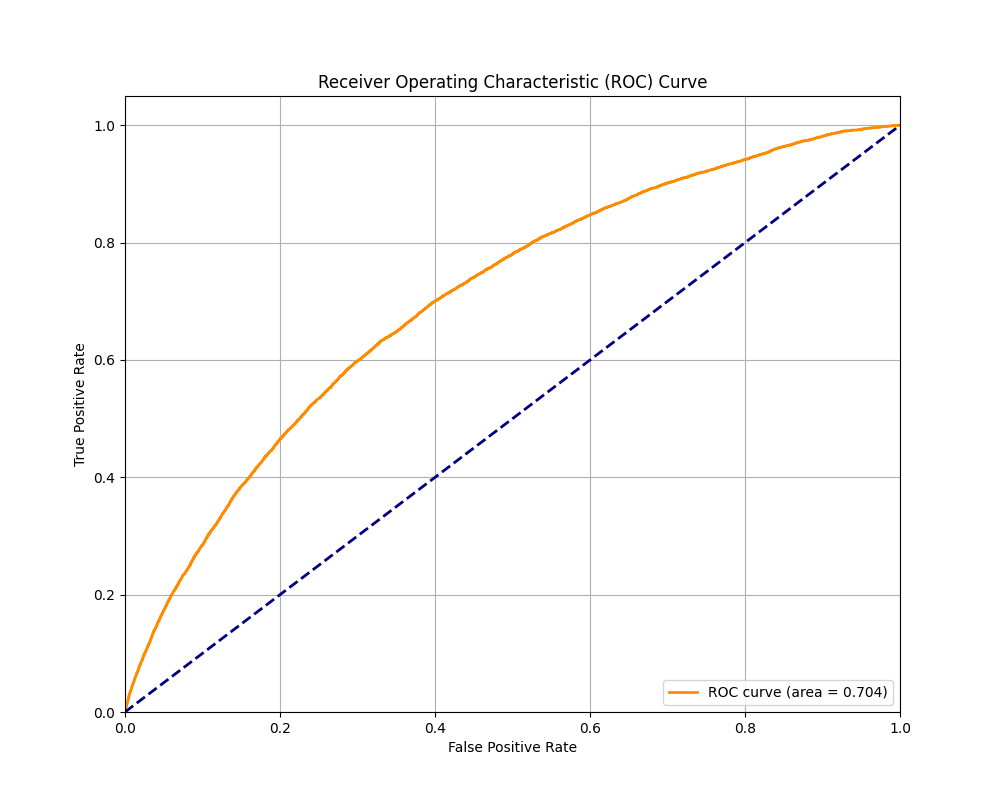

In [59]:
# ROC Curve
# Import required libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Create the ROC curve
fpr, tpr, _ = roc_curve(pred_pandas["loan_status_binary"], pred_pandas["probability_1"])
roc_auc_sklearn = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_sklearn:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Use the magic command to display the plot
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

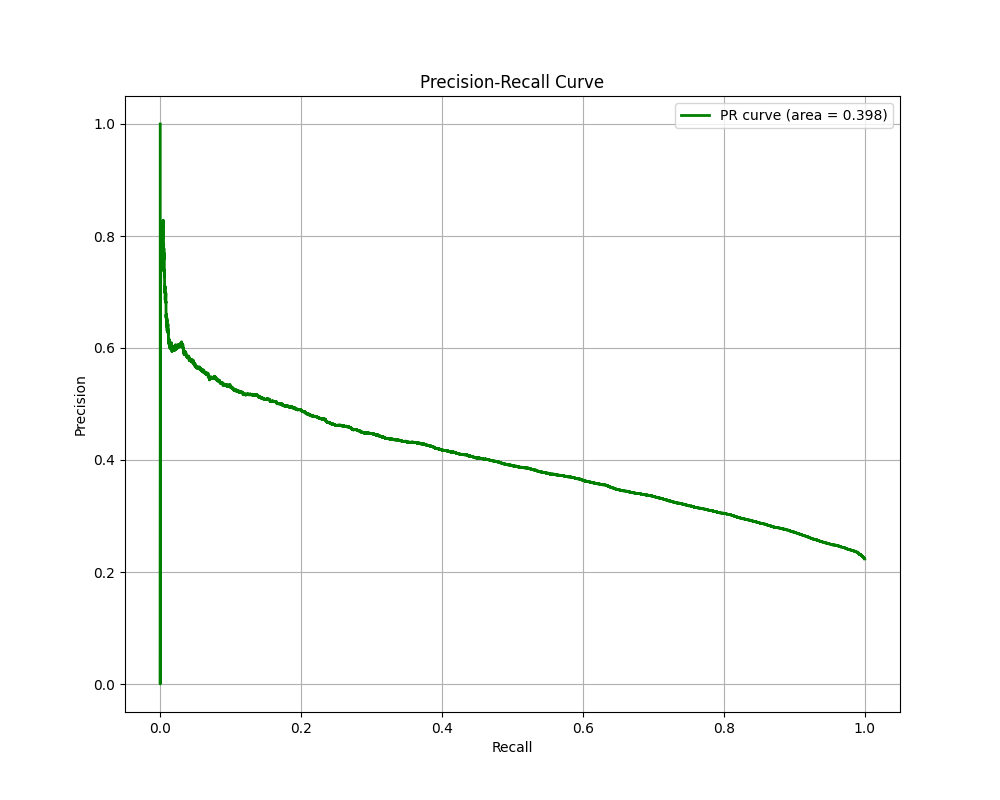

In [60]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(pred_pandas["loan_status_binary"], pred_pandas["probability_1"])
pr_auc_sklearn = auc(recall, precision)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (area = {pr_auc_sklearn:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Use the magic command to display the plot
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

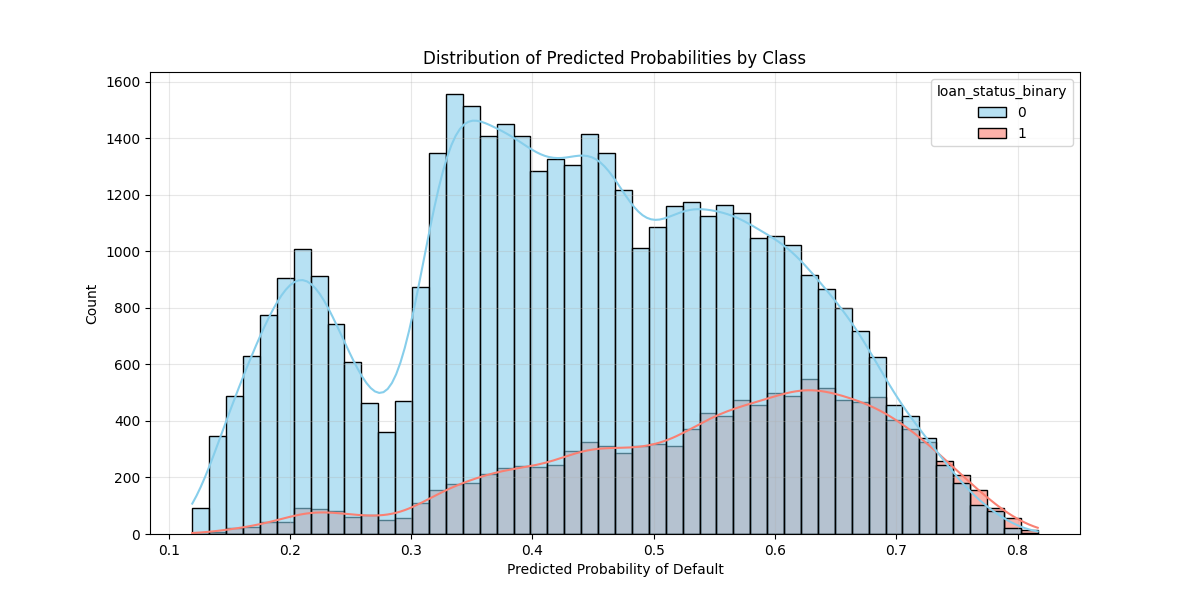

In [61]:
# Distribution of Prediction Probabilities
plt.figure(figsize=(12, 6))
sns.histplot(data=pred_pandas, x="probability_1", hue="loan_status_binary", bins=50, 
             alpha=0.6, palette=["skyblue", "salmon"], kde=True)
plt.title("Distribution of Predicted Probabilities by Class")
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

# Use the magic command to display the plot
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

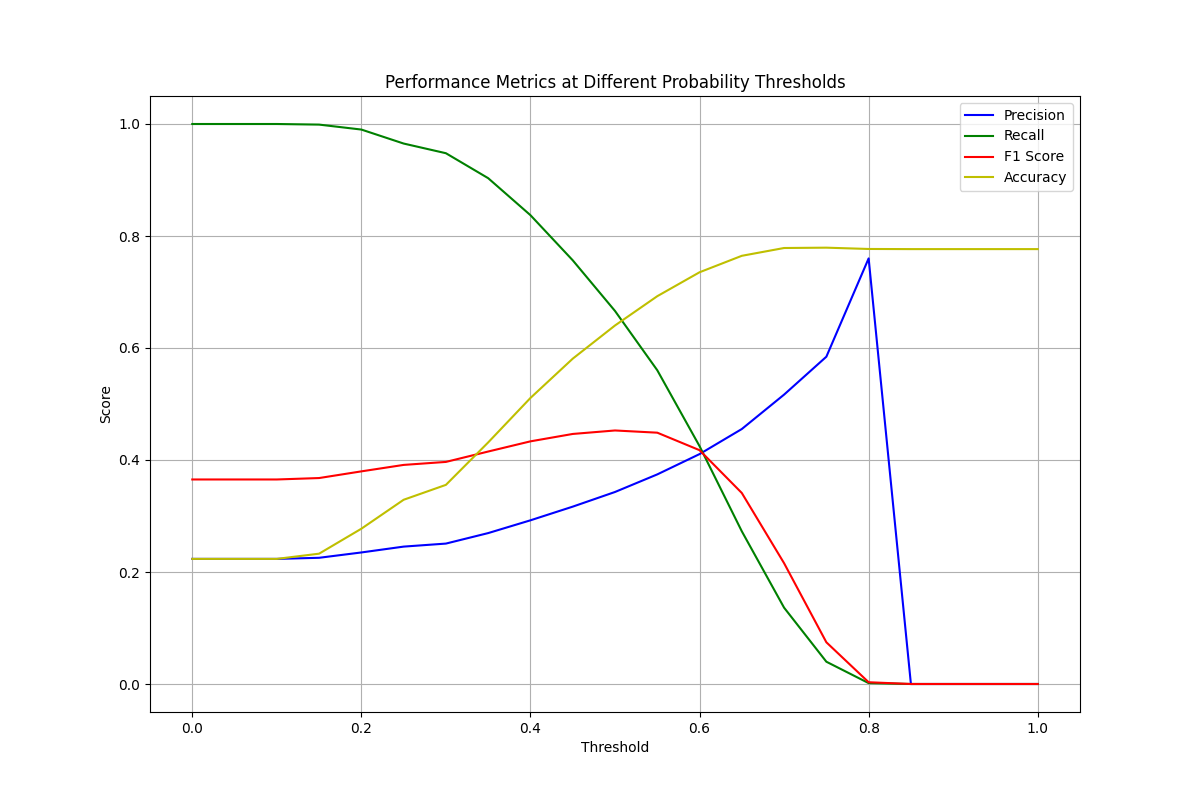

In [62]:
# Performance at Different Thresholds
thresholds = np.arange(0, 1.01, 0.05)
threshold_metrics = []

for threshold in thresholds:
    # Create predictions based on threshold
    pred_pandas["pred_at_threshold"] = (pred_pandas["probability_1"] >= threshold).astype(int)
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(pred_pandas["loan_status_binary"], pred_pandas["pred_at_threshold"]).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    threshold_metrics.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Plot metrics vs thresholds
plt.figure(figsize=(12, 8))
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision')
plt.plot(threshold_df['threshold'], threshold_df['recall'], 'g-', label='Recall')
plt.plot(threshold_df['threshold'], threshold_df['f1'], 'r-', label='F1 Score')
plt.plot(threshold_df['threshold'], threshold_df['accuracy'], 'y-', label='Accuracy')
plt.title('Performance Metrics at Different Probability Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Use the magic command to display the plot
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

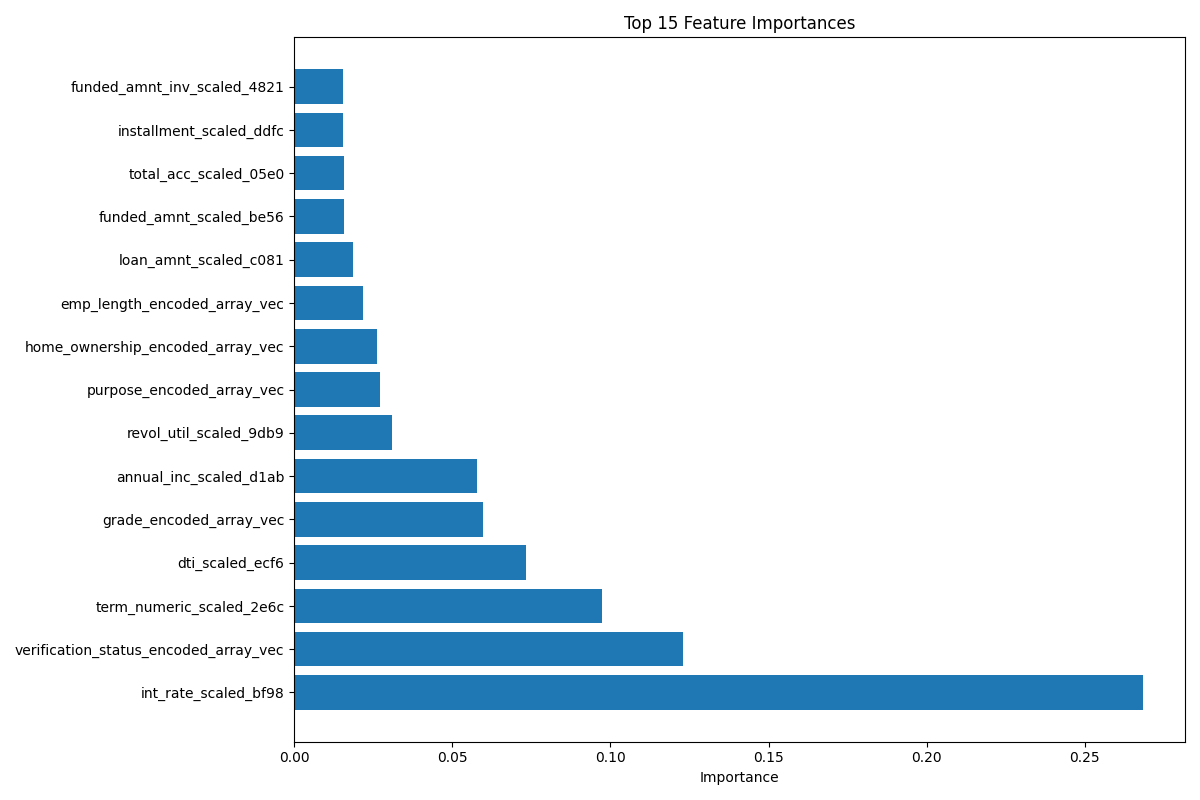

In [63]:
# Feature importance analysis
# Helps to understand which features have the most influence on the model's predictions

# Get feature importance
feature_importances = model.featureImportances

# Create list of (feature, importance) tuples
features_and_importances = [(feature_cols[i], float(feature_importances[i])) 
                           for i in range(len(feature_cols))]

# Sort by importance
sorted_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)

# Plot top features
top_n = 15  # Show top 15 features
top_features = sorted_importances[:top_n]
feature_names = [item[0] for item in top_features]
importance_values = [item[1] for item in top_features]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), importance_values, align='center')
plt.yticks(range(len(top_features)), feature_names)
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.tight_layout()

%matplot plt

In [64]:
print(f"Number of features used in the model: {len(feature_cols)}")
print("Feature columns:", feature_cols)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of features used in the model: 21
Feature columns: ['loan_amnt_scaled_c081', 'funded_amnt_scaled_be56', 'funded_amnt_inv_scaled_4821', 'int_rate_scaled_bf98', 'installment_scaled_ddfc', 'annual_inc_scaled_d1ab', 'dti_scaled_ecf6', 'delinq_2yrs_scaled_0b22', 'inq_last_6mths_scaled_b65e', 'open_acc_scaled_1a76', 'pub_rec_scaled_ac9f', 'revol_bal_scaled_5f91', 'revol_util_scaled_9db9', 'total_acc_scaled_05e0', 'term_numeric_scaled_2e6c', 'credit_history_length_scaled_bf03', 'grade_encoded_array_vec', 'emp_length_encoded_array_vec', 'home_ownership_encoded_array_vec', 'verification_status_encoded_array_vec', 'purpose_encoded_array_vec']